# Test Neural SDEs

`torchdyn` NeuralSDE implementation relies on XuChen Li's `torchsde` implementation of several SDE solvers and sensitivity analysis tools.

In this tutorial we briefly introduce NeuralSDEs in `torchdyn`, with basic implementation of both *Ito* and *Stratonivich* -type SDEs

TO DO:
* test noise types

In [1]:
import sys ; sys.path.append('../../')
from torchdyn.models import *
from torchdyn.datasets import *
from torchdyn import *

In [2]:
import torch 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torch.distributions import Uniform
prior = Uniform(-torch.ones(2).to(device), torch.ones(2).to(device))

## Stratonovich SDEs

In [18]:
f = nn.Sequential(nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 2))
g = nn.Sequential(nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 2))

nsde = NeuralSDE(f, g,
                noise_type='diagonal',
                sde_type='stratonovich',
                sensitivity='adjoint',
                s_span=torch.linspace(0, 1, 1000),
                solver='euler',
                atol=1e-4,
                rtol=1e-4).to(device)
#nsde.adaptive = True

In [19]:
# test backward adjoint
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
g1 = x0.grad
print(g1.shape)

# test backward autograd
nsde.sensitivity = 'autograd'
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
g2 = x0.grad
print(g2.shape)

torch.Size([100, 2])
torch.Size([100, 2])


In [20]:
g1 - g2

tensor([[ 1.1399e-01, -2.9576e-01],
        [-1.7419e-02,  3.1119e-01],
        [ 2.0935e-01, -7.0926e-01],
        [-4.5455e-04, -5.7783e-03],
        [ 4.8455e-02, -7.0892e-01],
        [-1.5910e-01,  5.1672e-01],
        [-1.7681e-01,  4.6715e-01],
        [-3.8691e-01,  7.6835e-01],
        [-3.4714e-01,  3.1353e-01],
        [-5.7080e-02, -3.0685e-01],
        [ 4.5262e-01, -4.9061e-01],
        [ 2.7030e-01, -3.0756e-01],
        [ 2.3194e-01, -5.5276e-01],
        [ 2.4739e-01, -5.2884e-01],
        [ 1.6920e-01, -5.9923e-01],
        [ 4.0380e-01, -1.0280e+00],
        [-5.2205e-02,  1.9112e-01],
        [-8.7919e-02, -5.2833e-02],
        [ 2.1903e-01, -1.0490e+00],
        [ 3.1303e-01, -6.1088e-01],
        [ 6.8690e-02, -4.2519e-01],
        [-1.8204e-01,  2.7016e-01],
        [ 1.7380e-01, -2.7827e-01],
        [ 3.2635e-01, -9.4291e-01],
        [-8.8046e-02,  1.6459e-01],
        [ 2.0505e-01, -5.0301e-01],
        [ 1.7130e-01, -3.7491e-01],
        [ 1.6439e-01, -3.984

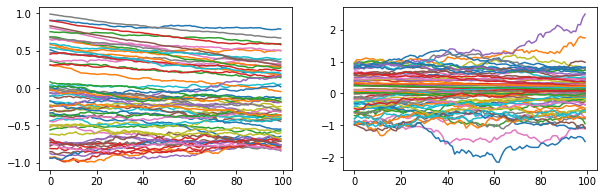

In [7]:
# test_trajectory
bs = 64 ; s_span = torch.linspace(0, 1, 100)
x0 = prior.sample(torch.Size([bs]))
traj = nsde.trajectory(x0, s_span).detach().cpu()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i in range(bs):
    ax[0].plot(traj[:,i,0])
    ax[1].plot(traj[:,i,1])

## Ito SDEs

In [8]:
f = nn.Sequential(nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 2))
g = nn.Sequential(nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 2))

nsde = NeuralSDE(f, g,
                noise_type='diagonal',
                sde_type='ito',
                sensitivity='adjoint',
                s_span=torch.linspace(0, 1, 100),
                solver='euler',
                atol=0.0001,
                rtol=0.0001).to(device)

In [9]:
# test backward adjoint
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)

# test backward autograd
nsde.sensitivity = 'autograd'
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)


torch.Size([100, 2])
torch.Size([100, 2])


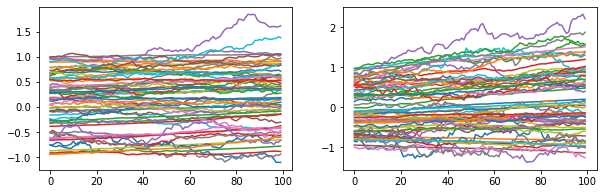

In [10]:
# test_trajectory
bs = 64 ; s_span = torch.linspace(0, 1, 100)
x0 = prior.sample(torch.Size([bs]))
traj = nsde.trajectory(x0, s_span).detach().cpu()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i in range(bs):
    ax[0].plot(traj[:,i,0])
    ax[1].plot(traj[:,i,1])

## DepthCat in Drift and Diffusion

In [11]:
f = nn.Sequential(DepthCat(1), nn.Linear(3, 64), nn.Tanh(), nn.Linear(64, 2))
g = nn.Sequential(DepthCat(1), nn.Linear(3, 64), nn.Tanh(), nn.Linear(64, 2))

nsde = NeuralSDE(f, g,
                noise_type='diagonal',
                sde_type='ito',
                sensitivity='adjoint',
                s_span=torch.linspace(0, 1, 100),
                solver='euler',
                atol=0.0001,
                rtol=0.0001).to(device)

In [12]:
# test backward adjoint
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)

# test backward autograd
nsde.sensitivity = 'autograd'
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)

torch.Size([100, 2])
torch.Size([100, 2])


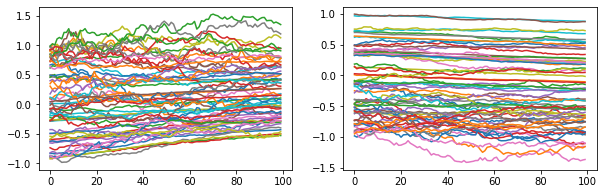

In [13]:
# test_trajectory
bs = 64 ; s_span = torch.linspace(0, 1, 100)
x0 = prior.sample(torch.Size([bs]))
traj = nsde.trajectory(x0, s_span).detach().cpu()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i in range(bs):
    ax[0].plot(traj[:,i,0])
    ax[1].plot(traj[:,i,1])

## DataControl in Drift and Diffusion

In [14]:
f = nn.Sequential(DataControl(), nn.Linear(4, 64), nn.Tanh(), nn.Linear(64, 2))
g = nn.Sequential(DataControl(), nn.Linear(4, 64), nn.Tanh(), nn.Linear(64, 2))

nsde = NeuralSDE(f, g,
                noise_type='diagonal',
                sde_type='ito',
                sensitivity='adjoint',
                s_span=torch.linspace(0, 1, 100),
                solver='euler',
                atol=0.0001,
                rtol=0.0001).to(device)

In [15]:
# test backward adjoint
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)

# test backward autograd
nsde.sensitivity = 'autograd'
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)

torch.Size([100, 2])
torch.Size([100, 2])


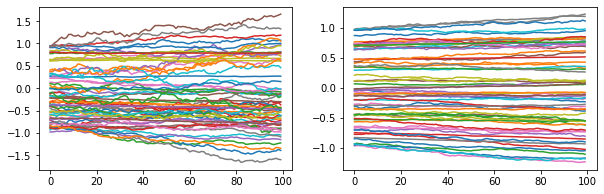

In [16]:
# test_trajectory
bs = 64 ; s_span = torch.linspace(0, 1, 100)
x0 = prior.sample(torch.Size([bs]))
traj = nsde.trajectory(x0, s_span).detach().cpu()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i in range(bs):
    ax[0].plot(traj[:,i,0])
    ax[1].plot(traj[:,i,1])

In [17]:
import torchsde

In [ ]:
torchsde.sdeint()